In [63]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

In [64]:
dataset = pd.read_csv('Datasets/final_feature_dataset.csv')
X = dataset.drop(['Winner', 'Home Goals', 'Away Goals', 'Season', 'Home Team', 'Away Team'], axis=1)
# X['Home Team'] = LabelEncoder().fit_transform(X['Home Team'])
# X['Away Team'] = LabelEncoder().fit_transform(X['Away Team'])
y = dataset['Winner']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [61]:
rf_model = RandomForestClassifier(bootstrap=False, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=1000)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
print('Accuracy:', accuracy_score(y_test, y_pred))

Accuracy: 0.7144736842105263


In [20]:
label_mapping = {-1: 0, 0: 1, 1: 2}

# Map the labels in y_train
y_train_ = np.array([label_mapping[label] for label in y_train])

# Map the labels in y_test
y_test_ = np.array([label_mapping[label] for label in y_test])

xgb_model = XGBClassifier(
    random_state=16,
    eval_metric='mlogloss',
    colsample_bytree=0.8,
    gamma=1,
    learning_rate=0.01,
    max_depth=7,
    n_estimators=2000,
    subsample=0.8
)
xgb_model.fit(X_train, y_train_)
y_pred = xgb_model.predict(X_test)
print('Accuracy:', accuracy_score(y_test_, y_pred))

Accuracy: 0.7210526315789474


In [36]:
gb_model = GradientBoostingClassifier(random_state=16, n_estimators=1000, learning_rate=0.5, max_depth=4)

gb_model.fit(X_train, y_train)
y_pred = gb_model.predict(X_test)
print('Accuracy:', accuracy_score(y_test, y_pred))

Accuracy: 0.6881578947368421


In [69]:
class ELO_Insights_model:
    def __init__(self):
        self.rf_model = RandomForestClassifier(bootstrap=False, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=1000)
        self.xgb_model = XGBClassifier(
            random_state=16,
            eval_metric='mlogloss',
            colsample_bytree=0.8,
            gamma=1,
            learning_rate=0.01,
            max_depth=7,
            n_estimators=2000,
            subsample=0.8
        )
        self.gb_model = GradientBoostingClassifier(random_state=16, n_estimators=1000, learning_rate=0.5, max_depth=4)
        # self.gaussian_model = GaussianNB()

    def fit(self, X_train, y_train):
        label_mapping = {-1: 0, 0: 1, 1: 2}
        y_train_ = np.array([label_mapping[label] for label in y_train])

        self.rf_model.fit(X_train, y_train)
        self.xgb_model.fit(X_train, y_train_)
        self.gb_model.fit(X_train, y_train)
        # self.gaussian_model.fit(X_train, y_train)

    def predict(self, X_test):
        # Get predictions from the models
        rf_pred = self.rf_model.predict(X_test)
        xgb_pred = self.xgb_model.predict(X_test)
        gb_pred = self.gb_model.predict(X_test)
        # gaussian_pred = self.gaussian_model.predict(X_test)

        label_mapping = {0: -1, 1: 0, 2: 1}
        xgb_pred_mapped = np.vectorize(label_mapping.get)(xgb_pred)

        all_preds = np.vstack((rf_pred, xgb_pred_mapped, gb_pred)).T  # Shape: (num_samples, num_models)

        # Calculate majority vote for each sample
        result = np.apply_along_axis(
            lambda x: np.bincount(x + 1).argmax() - 1, axis=1, arr=all_preds
        )

        return result

    def score(self, y_pred, y_test):
        return np.mean(y_pred == y_test)
        

Accuracy: 0.725


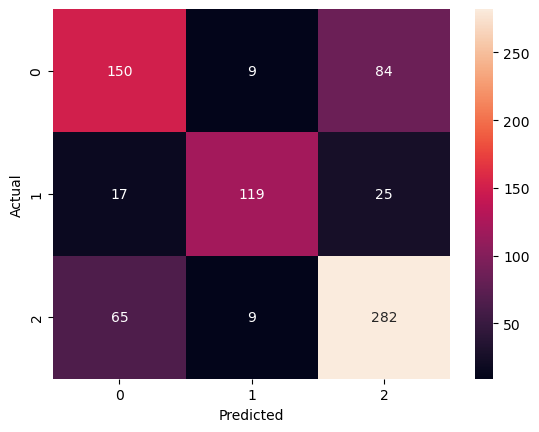

In [70]:
elo_model = ELO_Insights_model()
elo_model.fit(X_train, y_train)
y_pred = elo_model.predict(X_test)
print('Accuracy:', elo_model.score(y_pred, y_test))

conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [50]:
print(X.columns)


Index(['Home Team ELO', 'Away Team ELO', 'Home XG', 'Away XG', 'Home XGA',
       'Away XGA', 'Home Win Percentage', 'Home Draw Percentage',
       'Away Win Percentage', 'Away Draw Percentage', 'Home Team Form',
       'Away Team Form', 'Home Team Cumulative Points',
       'Away Team Cumulative Points'],
      dtype='object')


In [52]:
from sklearn.decomposition import PCA

for components in [1,2,5,10]:
    pca = PCA(n_components=components)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    elo_model.fit(X_train_pca, y_train)
    y_pred = elo_model.predict(X_test_pca)
    print(f'Accuracy with PCA {components}: {elo_model.score(y_pred, y_test)}')


Accuracy with PCA 1: 0.5263157894736842
Accuracy with PCA 2: 0.5434210526315789
Accuracy with PCA 5: 0.6671052631578948
Accuracy with PCA 10: 0.6842105263157895


In [53]:
from sklearn.feature_selection import RFE

for n_features in [1,2,5,10]:
    rfe = RFE(estimator=rf_model, n_features_to_select=n_features)
    X_train_rfe = rfe.fit_transform(X_train, y_train)
    X_test_rfe = rfe.transform(X_test)
    elo_model.fit(X_train_rfe, y_train)
    y_pred = elo_model.predict(X_test_rfe)
    print(f'Accuracy with RFE {n_features}: {elo_model.score(y_pred, y_test)}')
    print(f'Selected features: {X.columns[rfe.support_]}')

Accuracy with RFE 1: 0.49078947368421055
Selected features: Index(['Away Team ELO'], dtype='object')
Accuracy with RFE 2: 0.6039473684210527
Selected features: Index(['Away Team ELO', 'Home XGA'], dtype='object')
Accuracy with RFE 5: 0.6934210526315789
Selected features: Index(['Home Team ELO', 'Away Team ELO', 'Away XG', 'Home XGA',
       'Away Win Percentage'],
      dtype='object')
Accuracy with RFE 10: 0.7171052631578947
Selected features: Index(['Home Team ELO', 'Away Team ELO', 'Home XG', 'Away XG', 'Home XGA',
       'Away XGA', 'Home Win Percentage', 'Home Draw Percentage',
       'Away Win Percentage', 'Away Draw Percentage'],
      dtype='object')


In [88]:
team_data = pd.read_csv('Datasets/2023-2024_team_data.csv')
final_standings = {team:0 for team in team_data['Team']}
fixtures = pd.read_csv('Datasets/fixtures-2025.csv')
team_data.head()

,Team,ELO,XG,XGA,Win Percentage,Draw Percentage,Team Form,Team Cumulative Points
0,Manchester Utd,1641,57.0,73.0,60.55,21.94,0.333333,57
1,Leicester City,1485,49.0,54.0,33.44,25.73,0.200000,31
2,Everton,1580,30.0,60.0,35.78,27.81,0.666667,48
3,West Ham,1574,36.0,75.0,33.61,25.23,0.266667,52
4,Tottenham,1640,85.0,65.0,43.93,23.90,0.200000,63


In [89]:
elo_model = ELO_Insights_model()
elo_model.fit(X, y)

In [ ]:
for i, row in fixtures.iterrows():
    home_team = row['home']
    away_team = row['away']
    home_ELO = team_data[team_data['Team'] == home_team]['ELO'].values[0]
    home_XG = team_data[team_data['Team'] == home_team]['XG'].values[0]
    home_XGA = team_data[team_data['Team'] == home_team]['XGA'].values[0]
    home_win_percentage = team_data[team_data['Team'] == home_team]['Win Percentage'].values[0]
    home_draw_percentage = team_data[team_data['Team'] == home_team]['Draw Percentage'].values[0]
    home_team_form = team_data[team_data['Team'] == home_team]['Team Form'].values[0]
    home_team_cumulative_points = team_data[team_data['Team'] == home_team]['Team Cumulative Points'].values[0]

    away_ELO = team_data[team_data['Team'] == away_team]['ELO'].values[0]
    away_XG = team_data[team_data['Team'] == away_team]['XG'].values[0]
    away_XGA = team_data[team_data['Team'] == away_team]['XGA'].values[0]
    away_win_percentage = team_data[team_data['Team'] == away_team]['Win Percentage'].values[0]
    away_draw_percentage = team_data[team_data['Team'] == away_team]['Draw Percentage'].values[0]
    away_team_form = team_data[team_data['Team'] == away_team]['Team Form'].values[0]
    away_team_cumulative_points = team_data[team_data['Team'] == away_team]['Team Cumulative Points'].values[0]
    
    entry = [
        home_ELO,                    # Corresponds to 'Home Team ELO'
        away_ELO,                    # Corresponds to 'Away Team ELO'
        home_XG,                     # Corresponds to 'Home Team XG'
        away_XG,                     # Corresponds to 'Away Team XG'
        home_XGA,                    # Corresponds to 'Home Team XGA'
        away_XGA,                    # Corresponds to 'Away Team XGA'
        home_win_percentage,         # Corresponds to 'Home Team Win Percentage'
        home_draw_percentage,        # Corresponds to 'Home Team Draw Percentage'
        away_win_percentage,         # Corresponds to 'Away Team Win Percentage'
        away_draw_percentage,        # Corresponds to 'Away Team Draw Percentage'
        home_team_form,              # Corresponds to 'Home Team Form'
        away_team_form,              # Corresponds to 'Away Team Form'
        home_team_cumulative_points, # Corresponds to 'Home Team Cumulative Points'
        away_team_cumulative_points  # Corresponds to 'Away Team Cumulative Points'

    ]
    entry_df = pd.DataFrame([entry], columns=X_train.columns)
    print(entry_df)

    predicted_result = elo_model.predict(entry_df)
    print(f'{home_team} vs {away_team}: {predicted_result[0]}')

    if predicted_result[0] == 1:
        final_standings[home_team] += 3

    elif predicted_result[0] == 0:
        final_standings[home_team] += 1
        final_standings[away_team] += 1

    elif predicted_result[0] == -1:
        final_standings[away_team] += 3



In [91]:
final_standings = dict(sorted(final_standings.items(), key=lambda item: item[1], reverse=True))
for team in final_standings:
    print(f'{team}: {final_standings[team]}')


Tottenham: 78
Chelsea: 72
Arsenal: 68
Liverpool: 68
Manchester City: 66
Manchester Utd: 64
Fulham: 62
Ipswich Town: 51
Leicester City: 48
Newcastle Utd: 48
Nottingham Forest: 48
Crystal Palace: 38
Aston Villa: 33
Bournemouth: 32
Southampton: 31
Wolves: 29
Brighton: 28
Brentford: 28
Everton: 27
West Ham: 25


In [103]:
team_data = pd.read_csv('Datasets/2022-2023_team_data.csv')
final_standings = {team:0 for team in team_data['Team']}
team_data.head()

,Team,ELO,XG,XGA,Win Percentage,Draw Percentage,Team Form,Team Cumulative Points
0,Manchester Utd,1706,78.0,40.0,60.98,22.12,0.600000,72
1,Everton,1505,42.0,36.0,35.74,27.92,0.333333,33
2,West Ham,1562,64.0,53.0,33.49,25.19,0.400000,40
3,Tottenham,1614,67.0,49.0,43.65,24.16,0.266667,57
4,Aston Villa,1650,55.0,77.0,34.51,28.19,0.466667,58


In [104]:
fixtures_23 = dataset[dataset['Season'] == '2023-2024']

for i, row in fixtures_23.iterrows():
    home_team = row['Home Team']
    away_team = row['Away Team']
    home_ELO = team_data[team_data['Team'] == home_team]['ELO'].values[0]
    home_XG = team_data[team_data['Team'] == home_team]['XG'].values[0]
    home_XGA = team_data[team_data['Team'] == home_team]['XGA'].values[0]
    home_win_percentage = team_data[team_data['Team'] == home_team]['Win Percentage'].values[0]
    home_draw_percentage = team_data[team_data['Team'] == home_team]['Draw Percentage'].values[0]
    home_team_form = team_data[team_data['Team'] == home_team]['Team Form'].values[0]
    home_team_cumulative_points = team_data[team_data['Team'] == home_team]['Team Cumulative Points'].values[0]

    away_ELO = team_data[team_data['Team'] == away_team]['ELO'].values[0]
    away_XG = team_data[team_data['Team'] == away_team]['XG'].values[0]
    away_XGA = team_data[team_data['Team'] == away_team]['XGA'].values[0]
    away_win_percentage = team_data[team_data['Team'] == away_team]['Win Percentage'].values[0]
    away_draw_percentage = team_data[team_data['Team'] == away_team]['Draw Percentage'].values[0]
    away_team_form = team_data[team_data['Team'] == away_team]['Team Form'].values[0]
    away_team_cumulative_points = team_data[team_data['Team'] == away_team]['Team Cumulative Points'].values[0]
    
    entry = [
        home_ELO,                    # Corresponds to 'Home Team ELO'
        away_ELO,                    # Corresponds to 'Away Team ELO'
        home_XG,                     # Corresponds to 'Home Team XG'
        away_XG,                     # Corresponds to 'Away Team XG'
        home_XGA,                    # Corresponds to 'Home Team XGA'
        away_XGA,                    # Corresponds to 'Away Team XGA'
        home_win_percentage,         # Corresponds to 'Home Team Win Percentage'
        home_draw_percentage,        # Corresponds to 'Home Team Draw Percentage'
        away_win_percentage,         # Corresponds to 'Away Team Win Percentage'
        away_draw_percentage,        # Corresponds to 'Away Team Draw Percentage'
        home_team_form,              # Corresponds to 'Home Team Form'
        away_team_form,              # Corresponds to 'Away Team Form'
        home_team_cumulative_points, # Corresponds to 'Home Team Cumulative Points'
        away_team_cumulative_points  # Corresponds to 'Away Team Cumulative Points'

    ]
    entry_df = pd.DataFrame([entry], columns=X_train.columns)

    predicted_result = elo_model.predict(entry_df)
    print(f'{home_team} vs {away_team}: {predicted_result[0]}')

    if predicted_result[0] == 1:
        final_standings[home_team] += 3

    elif predicted_result[0] == 0:
        final_standings[home_team] += 1
        final_standings[away_team] += 1

    elif predicted_result[0] == -1:
        final_standings[away_team] += 3



Arsenal vs Nott'ham Forest: 1
Chelsea vs Liverpool: 0
Newcastle Utd vs Aston Villa: 0
Manchester Utd vs Wolves: 1
Brighton vs Luton Town: 0
Bournemouth vs West Ham: 1
Everton vs Fulham: 1
Brentford vs Tottenham: -1
Burnley vs Manchester City: 0
Sheffield Utd vs Crystal Palace: 1
Manchester City vs Newcastle Utd: 0
Liverpool vs Bournemouth: 1
Aston Villa vs Everton: -1
Tottenham vs Manchester Utd: 0
West Ham vs Chelsea: 0
Crystal Palace vs Arsenal: 0
Fulham vs Brentford: 1
Wolves vs Brighton: -1
Nott'ham Forest vs Sheffield Utd: 0
Luton Town vs Burnley: 0
Arsenal vs Fulham: 1
Chelsea vs Luton Town: 0
Newcastle Utd vs Liverpool: 0
Manchester Utd vs Nott'ham Forest: 1
Brighton vs West Ham: 1
Bournemouth vs Tottenham: -1
Everton vs Wolves: 1
Brentford vs Crystal Palace: 0
Burnley vs Aston Villa: 1
Sheffield Utd vs Manchester City: -1
Manchester City vs Fulham: 1
Arsenal vs Manchester Utd: 0
Liverpool vs Aston Villa: 1
Chelsea vs Nott'ham Forest: 0
Crystal Palace vs Wolves: 0
Brighton vs Ne

In [105]:
print('Final Standings for 2023-2024 season')
final_standings = dict(sorted(final_standings.items(), key=lambda item: item[1], reverse=True))
for team in final_standings:
    print(f'{team}: {final_standings[team]}')


Final Standings for 2023-2024 season
Tottenham: 92
Manchester Utd: 68
Liverpool: 68
Manchester City: 63
Everton: 62
Arsenal: 60
Newcastle Utd: 58
Chelsea: 51
Burnley: 49
Luton Town: 46
West Ham: 43
Sheffield Utd: 41
Brighton: 38
Brentford: 35
Bournemouth: 32
Fulham: 31
Nott'ham Forest: 31
Crystal Palace: 28
Aston Villa: 25
Wolves: 23


In [115]:
team_data = pd.read_csv('Datasets/2021-2022_team_data.csv')
final_standings = {team:0 for team in team_data['Team']}
team_data.head()

,Team,ELO,XG,XGA,Win Percentage,Draw Percentage,Team Form,Team Cumulative Points
0,Manchester Utd,1646,40.0,55.0,61.08,22.37,0.266667,58
1,Everton,1532,47.0,59.0,36.32,27.83,0.666667,39
2,West Ham,1609,46.0,49.0,33.67,25.35,0.333333,56
3,Tottenham,1706,79.0,41.0,43.53,24.43,0.733333,68
4,Aston Villa,1555,24.0,50.0,34.14,28.47,0.533333,45


In [116]:
fixtures_23 = dataset[dataset['Season'] == '2022-2023']

for i, row in fixtures_23.iterrows():

    home_team = row['Home Team']
    away_team = row['Away Team']

    print(f'{home_team} vs {away_team}')
    home_ELO = team_data[team_data['Team'] == home_team]['ELO'].values[0]
    home_XG = team_data[team_data['Team'] == home_team]['XG'].values[0]
    home_XGA = team_data[team_data['Team'] == home_team]['XGA'].values[0]
    home_win_percentage = team_data[team_data['Team'] == home_team]['Win Percentage'].values[0]
    home_draw_percentage = team_data[team_data['Team'] == home_team]['Draw Percentage'].values[0]
    home_team_form = team_data[team_data['Team'] == home_team]['Team Form'].values[0]
    home_team_cumulative_points = team_data[team_data['Team'] == home_team]['Team Cumulative Points'].values[0]

    away_ELO = team_data[team_data['Team'] == away_team]['ELO'].values[0]
    away_XG = team_data[team_data['Team'] == away_team]['XG'].values[0]
    away_XGA = team_data[team_data['Team'] == away_team]['XGA'].values[0]
    away_win_percentage = team_data[team_data['Team'] == away_team]['Win Percentage'].values[0]
    away_draw_percentage = team_data[team_data['Team'] == away_team]['Draw Percentage'].values[0]
    away_team_form = team_data[team_data['Team'] == away_team]['Team Form'].values[0]
    away_team_cumulative_points = team_data[team_data['Team'] == away_team]['Team Cumulative Points'].values[0]
    
    entry = [
        home_ELO,                    # Corresponds to 'Home Team ELO'
        away_ELO,                    # Corresponds to 'Away Team ELO'
        home_XG,                     # Corresponds to 'Home Team XG'
        away_XG,                     # Corresponds to 'Away Team XG'
        home_XGA,                    # Corresponds to 'Home Team XGA'
        away_XGA,                    # Corresponds to 'Away Team XGA'
        home_win_percentage,         # Corresponds to 'Home Team Win Percentage'
        home_draw_percentage,        # Corresponds to 'Home Team Draw Percentage'
        away_win_percentage,         # Corresponds to 'Away Team Win Percentage'
        away_draw_percentage,        # Corresponds to 'Away Team Draw Percentage'
        home_team_form,              # Corresponds to 'Home Team Form'
        away_team_form,              # Corresponds to 'Away Team Form'
        home_team_cumulative_points, # Corresponds to 'Home Team Cumulative Points'
        away_team_cumulative_points  # Corresponds to 'Away Team Cumulative Points'

    ]
    entry_df = pd.DataFrame([entry], columns=X_train.columns)

    predicted_result = elo_model.predict(entry_df)
    print(f'{home_team} vs {away_team}: {predicted_result[0]}')

    if predicted_result[0] == 1:
        final_standings[home_team] += 3

    elif predicted_result[0] == 0:
        final_standings[home_team] += 1
        final_standings[away_team] += 1

    elif predicted_result[0] == -1:
        final_standings[away_team] += 3



Crystal Palace vs Arsenal
Crystal Palace vs Arsenal: 1
Fulham vs Liverpool
Fulham vs Liverpool: 0
Tottenham vs Southampton
Tottenham vs Southampton: 1
Newcastle Utd vs Nott'ham Forest
Newcastle Utd vs Nott'ham Forest: 0
Leeds United vs Wolves
Leeds United vs Wolves: 0
Bournemouth vs Aston Villa
Bournemouth vs Aston Villa: 0
Everton vs Chelsea
Everton vs Chelsea: 0
Leicester City vs Brentford
Leicester City vs Brentford: -1
Manchester Utd vs Brighton
Manchester Utd vs Brighton: -1
West Ham vs Manchester City
West Ham vs Manchester City: 0
Aston Villa vs Everton
Aston Villa vs Everton: 0
Manchester City vs Bournemouth
Manchester City vs Bournemouth: 1
Southampton vs Leeds United
Southampton vs Leeds United: 0
Wolves vs Fulham
Wolves vs Fulham: 0
Arsenal vs Leicester City
Arsenal vs Leicester City: 1
Brighton vs Newcastle Utd
Brighton vs Newcastle Utd: 1
Brentford vs Manchester Utd
Brentford vs Manchester Utd: 1
Nott'ham Forest vs West Ham
Nott'ham Forest vs West Ham: 1
Chelsea vs Tottenh

In [117]:
print('Final Standings for 2022-2023 Season')
final_standings = dict(sorted(final_standings.items(), key=lambda item: item[1], reverse=True))
for team in final_standings:
    print(f'{team}: {final_standings[team]}')


Final Standings for 2022-2023 Season
Arsenal: 76
Tottenham: 72
Chelsea: 72
Liverpool: 68
Manchester City: 68
Newcastle Utd: 67
Brighton: 43
Fulham: 42
Brentford: 42
Crystal Palace: 39
Everton: 36
Leeds United: 36
Manchester Utd: 34
Nott'ham Forest: 34
West Ham: 33
Leicester City: 33
Bournemouth: 32
Wolves: 32
Southampton: 31
Aston Villa: 28
